<a href="https://colab.research.google.com/github/screemix/raai_neuro/blob/main/Logit_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install allensdk

In [2]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import random 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [87]:
def generate_time_array(time, spikes, shift):
  time_array = []
  for i, t in enumerate(time):
    time_array.append(i+shift in spikes)
  return time_array

def generate_dataset(v, time, window_feat=30, window_pred=10, shift=1, balanced=True):
  n = len(v)
  x_positive = []
  x_negative = []
  y_positive = []
  y_negative = []

  window = window_pred + window_feat

  for i in range(0, n-window, shift):  
    v_temp = v[i:i+window_feat]
    
    if True in time[i+window_feat:i+window]:
      x_positive.append(v_temp)
    else:
      x_negative.append(v_temp)

  if balanced:
    x_negative_subsample = random.sample(x_negative, len(x_positive))
  else:
    x_negative_subsample = x_negative
  x = x_negative_subsample + x_positive
  y = [0 for i in x_negative_subsample] + [1 for i in x_positive]
  
  return {"x": np.stack(x), "y": np.array(y)}

def generate_scatters(logits, time, window_feat=30, window_pred=10, y=19):
  points = {"x": [], "y": []}

  for i, spike in enumerate(logits):
    if spike == 0:
      continue

    low = i + window_feat
    high = i + window_feat + window_pred
    x = (low + high) / 2
    points["x"].append(time[int(x)])
    points["y"].append(y)

  return points

In [49]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

cell_specimen_id = 464212183
data_set = ctc.get_ephys_data(cell_specimen_id)

/usr/local/lib/python3.7/dist-packages/allensdk/core/nwb_data_set.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stimulus = stimulus_dataset.value
/usr/local/lib/python3.7/dist-packages/allensdk/core/nwb_data_set.py:109: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  response = swp['response']['timeseries']['data'].value
/usr/local/lib/python3.7/dist-packages/allensdk/core/nwb_data_set.py:125: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_idx_start = swp['stimulus']['idx_start'].value
/usr/local/lib/python3.7/dist-packages/allensdk/core/nwb_data_set.py:126: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_length = swp['stimulus']['count'].value
/usr/local/lib/python3.7/dist-packages/allensdk/core/nwb_data_set.py:135: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  exp_idx_start = 

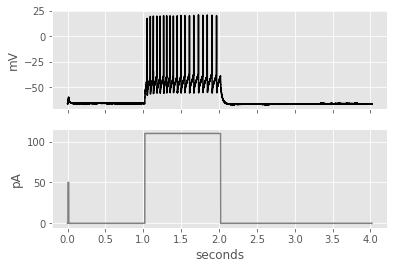

In [50]:
sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()

In [51]:
v_ = v[190000:410000]
i_ = i[190000:410000]

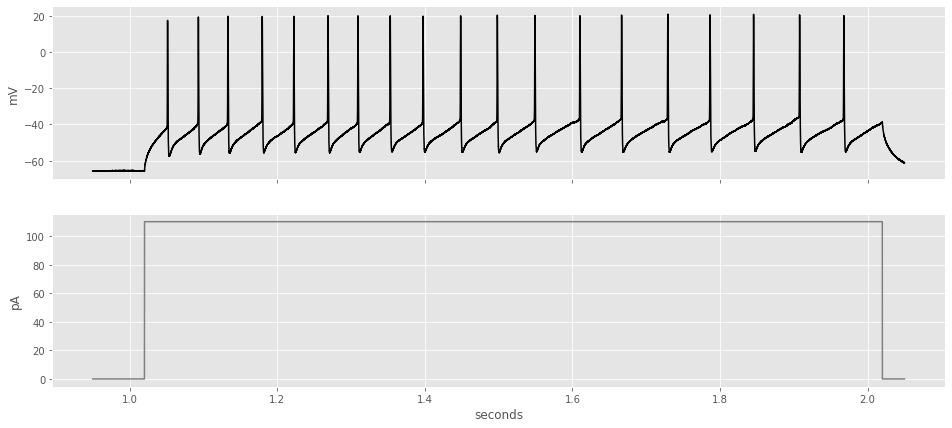

In [52]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16,7))
axes[0].plot(t[190000:410000], v[190000:410000], color='black')
axes[1].plot(t[190000:410000], i[190000:410000], color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()

In [ ]:
sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
sweep_ext.process_spikes()
spikes = sweep_ext.spike_feature("peak_index")

In [54]:
t_ = generate_time_array(t[190000:410000], spikes, shift=190000)

In [55]:
balanced_dataset = generate_dataset(v_, t_)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset["x"], balanced_dataset["y"], test_size=0.33, random_state=42, shuffle=True)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
logits = clf.predict(X_test)

In [57]:
accuracy_score(clf.predict(X_train), y_train)

0.9960629921259843

In [58]:
accuracy_score(logits, y_test)

1.0

In [91]:
dataset =  generate_dataset(v, generate_time_array(t, spikes, shift=0), balanced=False)

In [92]:
real_logits = clf.predict(dataset["x"])

In [93]:
scatters = generate_scatters(real_logits, t)

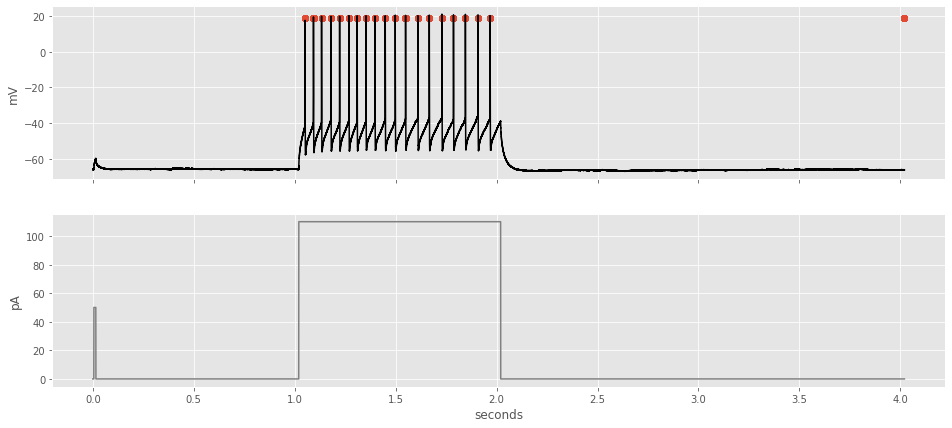

In [94]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16,7))
axes[0].plot(t, v, color='black')
axes[0].scatter(scatters["x"], scatters["y"])
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()